# Importing Libraries

In [4]:
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.window import Window
# from pyspark.sql.functions import * #lot of functions available here
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, log, isnan, count
from pyspark.ml.feature import Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline

import warnings
warnings.simplefilter(action='ignore')
from pyspark.sql.types import *

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Churn_Prediction_for_Telecom_Company").getOrCreate()
spark

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 43.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0f543803e6d33d3687db31c373c82f78aaec25a0dafc266dab9cd41856196948
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


# Importing the data

In [5]:
#Loading the dataset
df = spark.read.csv('/content/drive/MyDrive/churn.csv', header = True, inferSchema = True)
df.show(5, truncate = False)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|account length|area code|phone number|international plan|voice mail plan|number vmail messages|total day minutes|total day calls|total day charge|total eve minutes|total eve calls|total eve charge|total night minutes|total night calls|total night charge|total intl minutes|total intl calls|total intl charge|customer service calls|churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-------------

In [6]:
 df = df.select([F.col(col).alias(col.replace(' ', '_')) for col in df.columns])
 df.show(10)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-------------

In [7]:
df = df.drop('account_length','phone_number')

In [8]:
df.show(10)

+-----+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|
+-----+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   KS|      415|                no|            y

# Visualizing the data

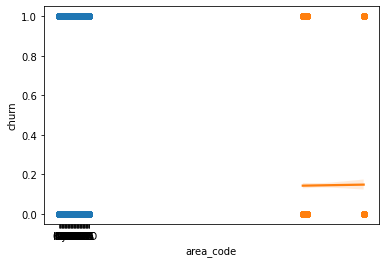

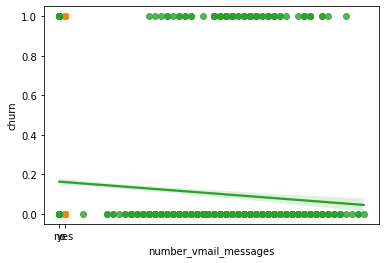

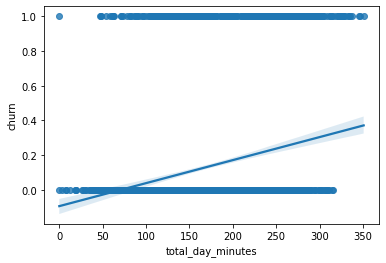

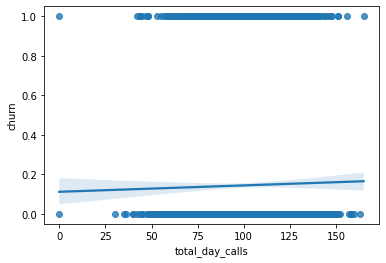

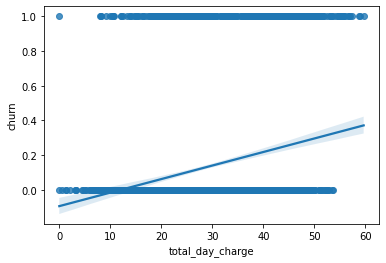

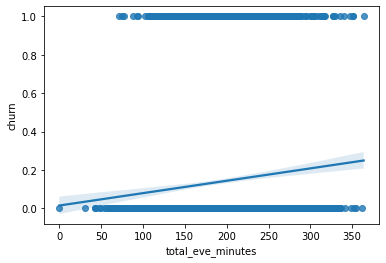

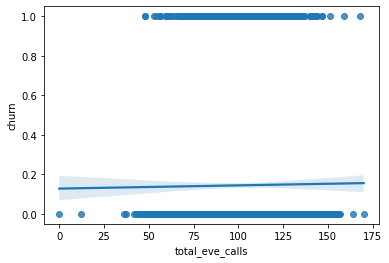

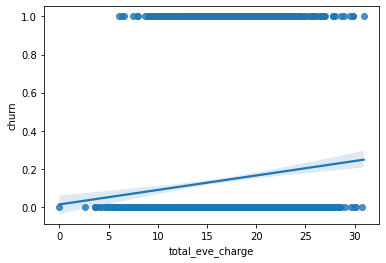

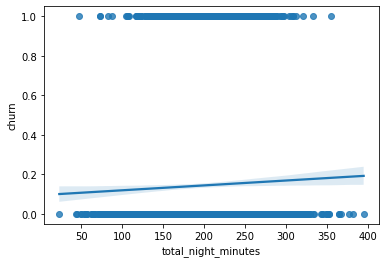

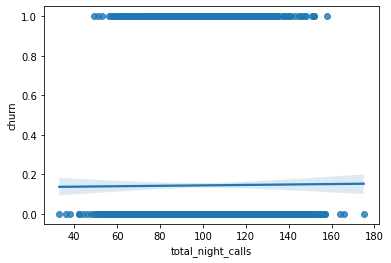

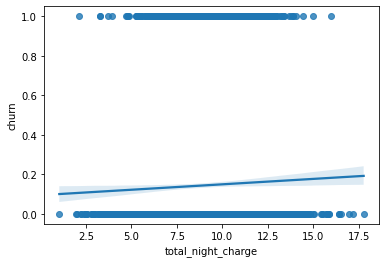

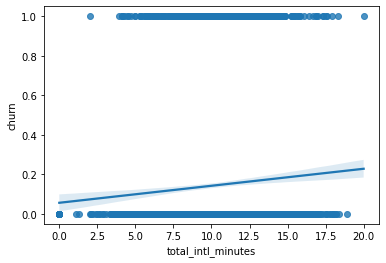

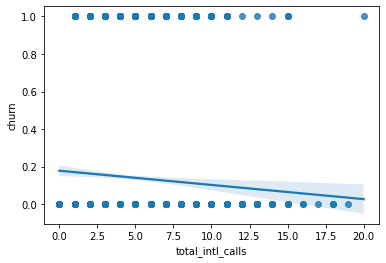

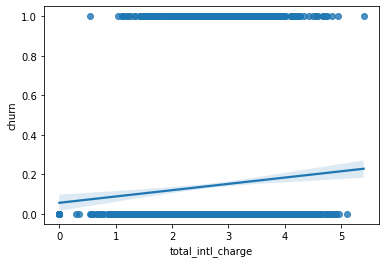

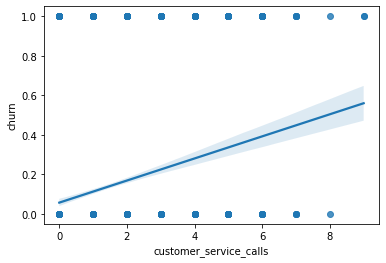

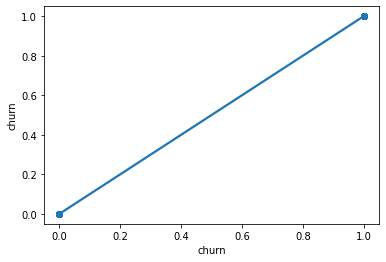

In [9]:
data2 = df.toPandas()

for col in data2.columns:
  try:
    sns.regplot(x= col, y= 'churn', data= data2 )
    plt.show()
  except:
    pass

With the above visualizations, we can conclude that "State" and "area_code" have the least relationship with Churn of a customer.

In [10]:
df = df.drop('State','area_code')

# Data Preparation

## Encoding

In [11]:
df.show(10)

+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|
+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|                no|            yes|                   25|            265.1|            110|     

In [12]:
input_col = ['international_plan','voice_mail_plan']
out_col = ['indexed_international_plan','indexed_voice_mail_plan']

In [13]:
indexer = StringIndexer(inputCols=input_col, outputCols=out_col) 
df = indexer.fit(df).transform(df) 
df.show(10)

+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+--------------------------+-----------------------+
|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|indexed_international_plan|indexed_voice_mail_plan|
+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+--

In [14]:
print('international_plan',df.select('international_plan').distinct().count(), 'Indexed_international_plan',df.select('Indexed_international_plan').distinct().count())

international_plan 2 Indexed_international_plan 2


In [15]:
print('voice_mail_plan',df.select('voice_mail_plan').distinct().count(), 'indexed_voice_mail_plan',df.select('indexed_voice_mail_plan').distinct().count())

voice_mail_plan 2 indexed_voice_mail_plan 2


In [16]:
print('churn',df.select('churn').distinct().show())

+-----+
|churn|
+-----+
| true|
|false|
+-----+

churn None


In [17]:
df = df.withColumn('label',F.when(df.churn == 'true', 1)
                                   .otherwise(0)
)

In [18]:
df.show(5)

+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+--------------------------+-----------------------+-----+
|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|indexed_international_plan|indexed_voice_mail_plan|label|
+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-------------

# Assembler

In [19]:
df.columns

['international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn',
 'indexed_international_plan',
 'indexed_voice_mail_plan',
 'label']

In [20]:
assembler = VectorAssembler(inputCols = ['number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'indexed_international_plan',
 'indexed_voice_mail_plan'], outputCol = "features")

In [21]:
data = assembler.transform(df).select('label','features')
data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[25.0,265.1,110.0...|
|    0|[26.0,161.6,123.0...|
|    0|[0.0,243.4,114.0,...|
|    0|[0.0,299.4,71.0,5...|
|    0|[0.0,166.7,113.0,...|
|    0|[0.0,223.4,98.0,3...|
|    0|[24.0,218.2,88.0,...|
|    0|[0.0,157.0,79.0,2...|
|    0|[0.0,184.5,97.0,3...|
|    0|[37.0,258.6,84.0,...|
+-----+--------------------+
only showing top 10 rows



# Train Test Split

In [22]:
train_df, test_df = data.randomSplit( [0.7, 0.3], seed = 42 )

# Model Building

In [23]:
rfm = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')
rfm = rfm.fit( train_df )

In [24]:
pred = rfm.transform(test_df)
pred.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(16,[1,2,3,4,5,6,...|[11.1209852459271...|[0.22241970491854...|       1.0|
|    0|[0.0,12.5,67.0,2....|[44.1899395994011...|[0.88379879198802...|       0.0|
|    0|[0.0,18.9,92.0,3....|[47.4832204031615...|[0.94966440806323...|       0.0|
|    0|[0.0,27.0,117.0,4...|[47.7888926716835...|[0.95577785343367...|       0.0|
|    0|[0.0,39.5,78.0,6....|[47.6873466106715...|[0.95374693221343...|       0.0|
|    0|[0.0,40.4,105.0,6...|[47.6815658103921...|[0.95363131620784...|       0.0|
|    0|[0.0,41.9,124.0,7...|[47.8069707155854...|[0.95613941431170...|       0.0|
|    0|[0.0,49.2,121.0,8...|[47.8069707155854...|[0.95613941431170...|       0.0|
|    0|[0.0,51.1,106.0,8...|[47.8069707155854...|[0.95613941431170...|       0.0|
|    0|[0.0,51.8

In [25]:
def train(train, test, classifier):
  # (train, test) = df.randomSplit([.7,.3])
  print(classifier)
  model = classifier.fit(train)

  pred = model.transform(test)

  eval_accuracy = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="accuracy"))
  
  eval_precision = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedPrecision"))
  
  eval_recall = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedRecall"))
  
  eval_f1 = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="f1"))

  accuracy = eval_accuracy.evaluate(pred)

  precision =  eval_precision.evaluate(pred)

  recall =  eval_recall.evaluate(pred)

  f1 =  eval_f1.evaluate(pred)

  print(f"""
  Accuracy  = {accuracy}
  Error     = {1-accuracy}
  Precision = {precision}
  Recall    = {recall}
  F1        = {f1}""")

  return model, pred

In [26]:
rfm2 = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')
_ , pred2 = train(train_df, test_df, rfm2)

pred2.select("prediction", "label", "features").show()

RandomForestClassifier_efc410ceef32

  Accuracy  = 0.9142857142857143
  Error     = 0.08571428571428574
  Precision = 0.9121152232179115
  Recall    = 0.9142857142857143
  F1        = 0.9046433261414055
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    0|(16,[1,2,3,4,5,6,...|
|       0.0|    0|[0.0,12.5,67.0,2....|
|       0.0|    0|[0.0,18.9,92.0,3....|
|       0.0|    0|[0.0,27.0,117.0,4...|
|       0.0|    0|[0.0,39.5,78.0,6....|
|       0.0|    0|[0.0,40.4,105.0,6...|
|       0.0|    0|[0.0,41.9,124.0,7...|
|       0.0|    0|[0.0,49.2,121.0,8...|
|       0.0|    0|[0.0,51.1,106.0,8...|
|       0.0|    0|[0.0,51.8,107.0,8...|
|       0.0|    0|[0.0,51.9,108.0,8...|
|       0.0|    0|[0.0,54.8,92.0,9....|
|       0.0|    0|[0.0,55.3,102.0,9...|
|       0.0|    0|[0.0,55.6,65.0,9....|
|       0.0|    0|[0.0,57.1,98.0,9....|
|       0.0|    0|[0.0,58.0,125.0,9...|
|       0.0|    0|[0.0,58.2,96.0,9...

In [27]:
summary = rfm.summary

In [28]:
summary.accuracy

0.9417922948073701

In [29]:
print('Area under ROC or train dataset',summary.areaUnderROC)
print('Area under ROC or test dataset',BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred))

Area under ROC or train dataset 0.9357522858071096
Area under ROC or test dataset 0.9028822055137848


In [30]:
test_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(16,[1,2,3,4,5,6,...|
|    0|[0.0,12.5,67.0,2....|
|    0|[0.0,18.9,92.0,3....|
|    0|[0.0,27.0,117.0,4...|
|    0|[0.0,39.5,78.0,6....|
|    0|[0.0,40.4,105.0,6...|
|    0|[0.0,41.9,124.0,7...|
|    0|[0.0,49.2,121.0,8...|
|    0|[0.0,51.1,106.0,8...|
|    0|[0.0,51.8,107.0,8...|
+-----+--------------------+
only showing top 10 rows



# Pipeline

## Data Preparation

In [47]:
df_2 = spark.read.csv('/content/drive/MyDrive/churn2.csv', header = True, inferSchema = True)

df_2 = df_2.select([F.col(col).alias(col.replace(' ', '_')) for col in df_2.columns])
df_2 = df_2.drop('account_length','phone_number')
df_2 = df_2.drop('State','area_code')

# df_2.show()
df_2 = df_2.na.drop(subset=["churn"])
df_2 = df_2.withColumn('label',F.when(df_2.churn == 'true', 1).otherwise(0))

## Setting Stages for pipelines

In [48]:
# String Indexer cols
input_col = ['international_plan','voice_mail_plan']
out_col = ['indexed_international_plan','indexed_voice_mail_plan']

# Vector Assembler

input_cols_vect = ['number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'indexed_international_plan',
 'indexed_voice_mail_plan']

# Fixing stage

In [53]:
# String Indexer
indexer = StringIndexer(inputCols=input_col, outputCols=out_col) 

# Vector Assembler
assembler = VectorAssembler(inputCols = input_cols_vect, outputCol = "features")

# ML Model
rfm = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

# Creating Pipeline
pipeline = Pipeline( stages= [indexer, assembler, rfm])

## Train Test split

In [50]:
train, test = df_2.randomSplit( [0.7, 0.3], seed = 42 )

# Model Fitting

In [54]:
model = pipeline.fit(train)
y_pred_train = model.transform(train)

In [55]:
y_pred_train.select('label', 'features', 'prediction').show(10)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|[0.0,0.0,0.0,0.0,...|       1.0|
|    0|[0.0,0.0,0.0,0.0,...|       0.0|
|    0|[0.0,7.9,100.0,1....|       0.0|
|    0|[0.0,17.6,121.0,2...|       0.0|
|    0|[0.0,18.9,92.0,3....|       0.0|
|    0|[0.0,34.0,133.0,5...|       0.0|
|    0|[0.0,39.5,78.0,6....|       0.0|
|    0|[0.0,40.4,105.0,6...|       0.0|
|    0|[0.0,41.9,124.0,7...|       0.0|
|    0|[0.0,49.2,121.0,8...|       0.0|
+-----+--------------------+----------+
only showing top 10 rows



In [56]:
y_pred_test = model.transform(test)
y_pred_test.select('label', 'features', 'prediction').show(10)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    0|[0.0,7.8,86.0,1.3...|       0.0|
|    0|[0.0,27.0,117.0,4...|       0.0|
|    0|[0.0,35.1,62.0,5....|       0.0|
|    0|[0.0,37.8,80.0,6....|       0.0|
|    0|[0.0,45.0,108.0,7...|       0.0|
|    0|[0.0,47.4,125.0,8...|       0.0|
|    0|[0.0,48.4,101.0,8...|       0.0|
|    0|[0.0,51.5,90.0,8....|       0.0|
|    0|[0.0,51.9,108.0,8...|       0.0|
|    0|[0.0,54.0,68.0,9....|       0.0|
+-----+--------------------+----------+
only showing top 10 rows

